In [19]:
# ------------------------------
# Cell 1 - Imports & Setup
# ------------------------------
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

# ------------------------------
# Cell 2 - Load Spanish Keywords
# ------------------------------
KEYWORDS_FILE = "dataset/multilingual_toxic_lexicon/es.parquet"
df = pd.read_parquet(KEYWORDS_FILE)
if "text" not in df.columns:
    raise ValueError("Expected column 'text' in keywords file")
keywords = df["text"].tolist()
print(f"Loaded {len(keywords)} Spanish keywords")

# ------------------------------
# Cell 3 - Embed Keywords
# ------------------------------
# Use a large multilingual embedding model
device = "cuda" if torch.cuda.is_available() else "cpu"
embedder = SentenceTransformer("Qwen/Qwen3-Embedding-0.6B")
keyword_embeddings = embedder.encode(keywords, batch_size=32, show_progress_bar=True, convert_to_numpy=True)
print("Embeddings shape:", keyword_embeddings.shape)

Loaded 1195 Spanish keywords


Batches: 100%|██████████| 38/38 [00:43<00:00,  1.15s/it]

Embeddings shape: (1195, 1024)


Found 181 clusters


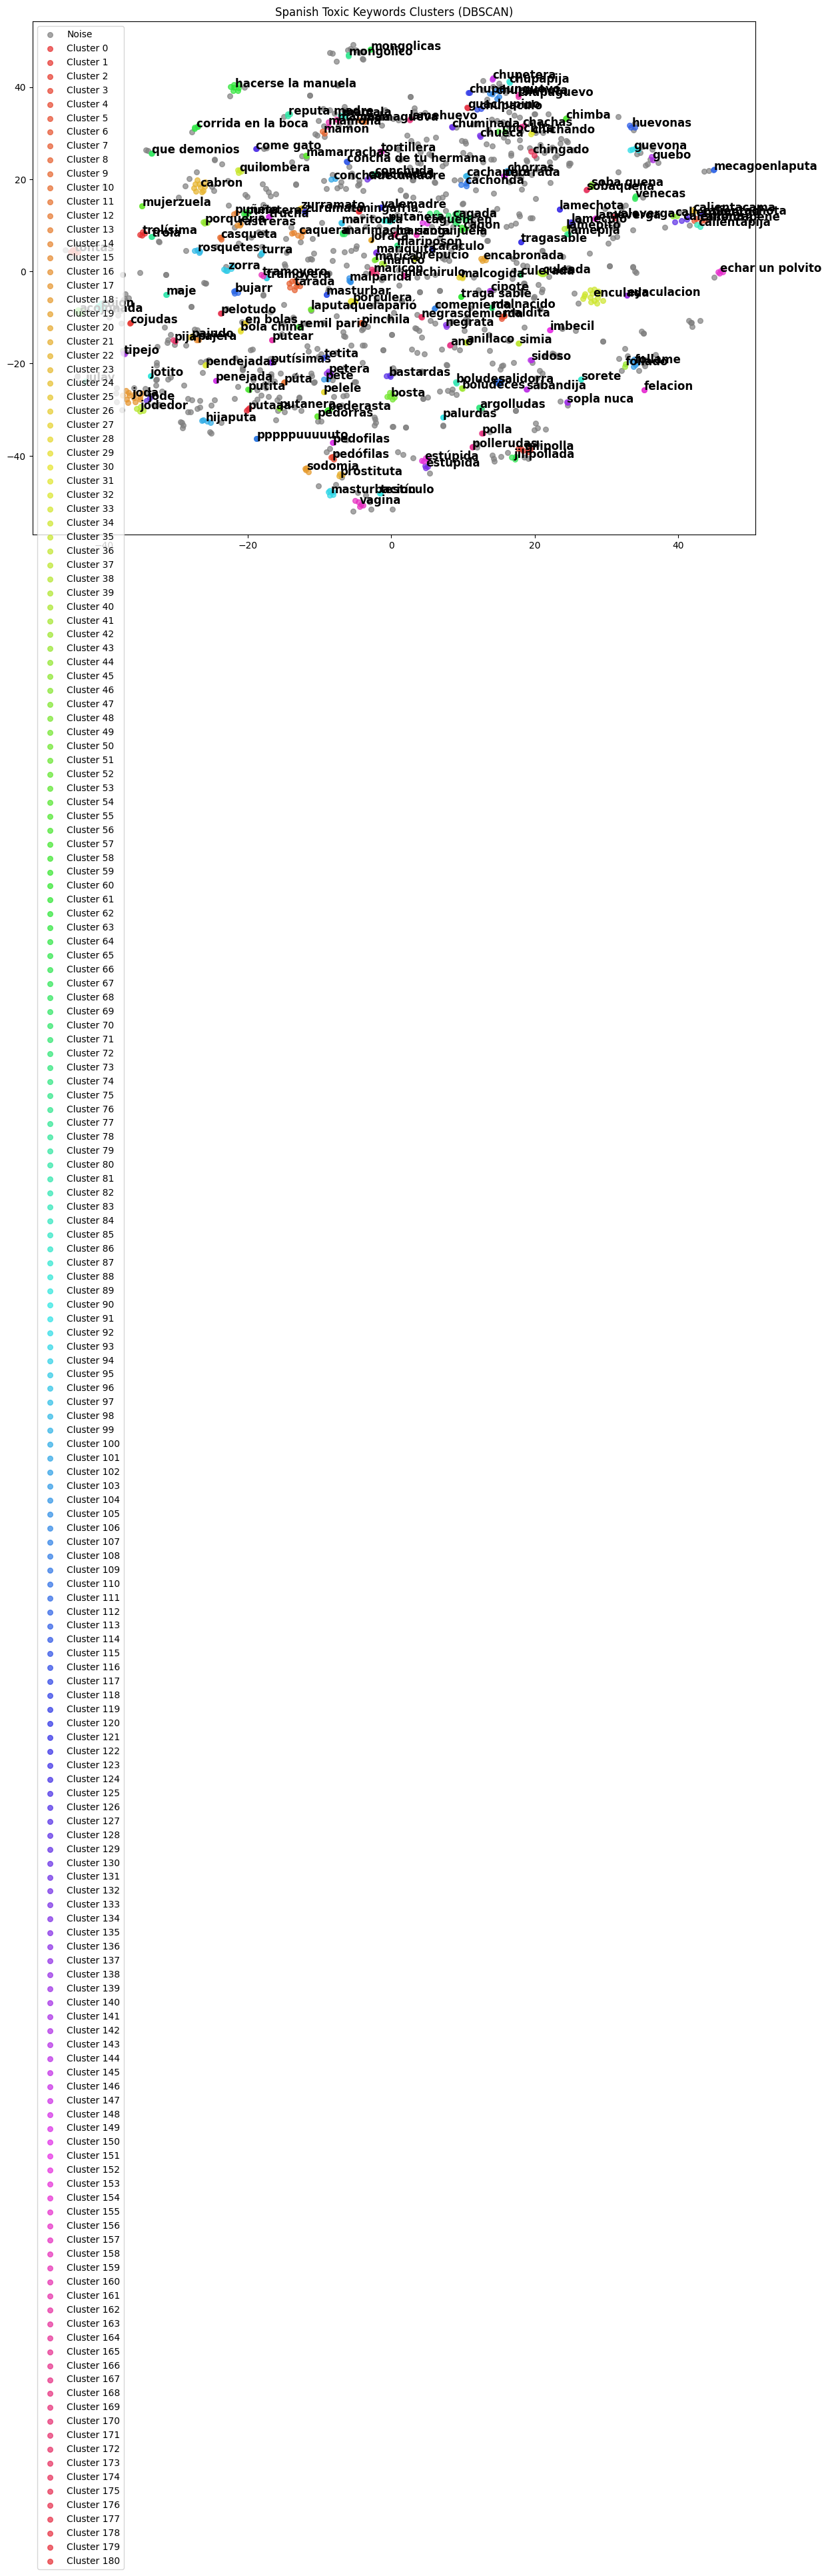


Re-clustering 675 noise points...
Recovered 0 new clusters from noise
Remaining noise points: 675

Total clusters after noise re-clustering: 181

Cluster 0 (tag: trolísima), size: 4
trolísimos, trolísimas, trolísima, trolísimo

Cluster 1 (tag: cojudas), size: 2
cojudos, cojudas

Cluster 2 (tag: gilipolla), size: 5
gilipolla, gilipollas, gilipolleces, gilipollada, gilipolladas

Cluster 3 (tag: tontas), size: 5
tontas, tontito, tontitos, tontitas, tontita

Cluster 4 (tag: pedófilas), size: 3
pedófilas, pedófilos, pedófilo

Cluster 5 (tag: maldita), size: 4
maldito, maldita, malditas, malditos

Cluster 6 (tag: calientapene), size: 4
calientapitos, calientapito, calientapene, calientapenes

Cluster 7 (tag: pinchila), size: 2
pinchilas, pinchila

Cluster 8 (tag: tarada), size: 8
taradas, tarada, taradita, taraditas, tarado, tarados, taraditos, taradito

Cluster 9 (tag: mamon), size: 2
mamon, mamonas

Cluster 10 (tag: casqueta), size: 3
casquetero, casqueta, casqueteros

Cluster 11 (tag: pú

PermissionError: [Errno 13] Permission denied: 'spanish_toxic_clusters.csv'

In [ ]:
# ------------------------------
# Cell 4 - Cluster with DBSCAN
# ------------------------------
# Default parameters
EPS = 0.08
MIN_SAMPLES = 2
PLOT_TAGS = True  # Flag to show cluster tags in the plot

# Perform clustering
clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric="cosine")
labels = clustering.fit_predict(keyword_embeddings)
num_clusters = len(set(labels)) - (1 if -1 in set(labels) else 0)
print(f"Found {num_clusters} clusters")

# ------------------------------
# Cell 5 - Compute cluster tags
# ------------------------------
# Choose your tagging strategy:
# "semantic" - most semantically central word (medoid)
# "alphabetical" - first word alphabetically (deterministic)
TAGGING_STRATEGY = "alphabetical"

cluster_tags = {}
for cluster_id in set(labels):
    cluster_idx = np.where(labels == cluster_id)[0]
    cluster_words = [keywords[i] for i in cluster_idx]
    
    if cluster_id == -1:
        cluster_tags[cluster_id] = "Noise"
        continue
    
    if TAGGING_STRATEGY == "semantic":
        # Find most semantically central word
        cluster_embs = keyword_embeddings[cluster_idx]
        sim_matrix = cosine_similarity(cluster_embs)
        dist_matrix = 1 - sim_matrix
        avg_distances = dist_matrix.mean(axis=1)
        central_idx = cluster_idx[np.argmin(avg_distances)]
        cluster_tags[cluster_id] = keywords[central_idx]
    
    elif TAGGING_STRATEGY == "alphabetical":
        # Simple deterministic: first alphabetically
        cluster_tags[cluster_id] = min(cluster_words)
    
    else:
        raise ValueError(f"Unknown tagging strategy: {TAGGING_STRATEGY}")

# ------------------------------
# Cell 6 - Visualize clusters in 2D with optional cluster tags
# ------------------------------
tsne = TSNE(n_components=2, random_state=42, metric="cosine")
emb_2d = tsne.fit_transform(keyword_embeddings)

plt.figure(figsize=(14,10))
unique_clusters = sorted(set(labels))
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)

def generate_distinct_colors(n):
    hues = np.linspace(0, 1, n, endpoint=False)
    return [mcolors.hsv_to_rgb([h, 0.8, 0.9]) for h in hues]

distinct_colors = generate_distinct_colors(num_clusters)
cluster_color_map = {}
color_idx = 0
for cluster_id in unique_clusters:
    if cluster_id == -1:
        cluster_color_map[cluster_id] = np.array([0.5, 0.5, 0.5])
    else:
        cluster_color_map[cluster_id] = distinct_colors[color_idx]
        color_idx += 1

for cluster_id in unique_clusters:
    cluster_idx = np.where(labels == cluster_id)[0]
    plt.scatter(
        emb_2d[cluster_idx,0],
        emb_2d[cluster_idx,1],
        c=[cluster_color_map[cluster_id]],
        label=f"Cluster {cluster_id}" if cluster_id != -1 else "Noise",
        s=30,
        alpha=0.7
    )
    
    if PLOT_TAGS and cluster_id != -1:
        centroid_2d = emb_2d[cluster_idx].mean(axis=0)
        plt.text(
            centroid_2d[0],
            centroid_2d[1],
            cluster_tags[cluster_id],
            fontsize=12,
            fontweight='bold',
            color='black'
        )

plt.title("Spanish Toxic Keywords Clusters (DBSCAN)")
plt.legend()
plt.show()

# ------------------------------
# Cell 7 - Re-cluster Noise Points
# ------------------------------
noise_idx = np.where(labels == -1)[0]

if len(noise_idx) > MIN_SAMPLES:
    print(f"\n{'='*60}")
    print(f"Re-clustering {len(noise_idx)} noise points...")
    print(f"{'='*60}")
    
    noise_embeddings = keyword_embeddings[noise_idx]
    
    # Use more relaxed parameters for noise (can adjust these)
    NOISE_MIN_SAMPLES = 2
    
    noise_clustering = DBSCAN(eps=EPS, min_samples=NOISE_MIN_SAMPLES, metric="cosine")
    noise_labels = noise_clustering.fit_predict(noise_embeddings)
    
    # Find max existing cluster ID
    max_cluster = labels[labels != -1].max() if len(labels[labels != -1]) > 0 else -1
    
    # Assign new cluster IDs to recovered clusters
    noise_cluster_count = 0
    for i, noise_label in enumerate(noise_labels):
        if noise_label != -1:
            labels[noise_idx[i]] = max_cluster + 1 + noise_label
            noise_cluster_count = max(noise_cluster_count, noise_label + 1)
    
    # Update cluster tags for new clusters
    for new_cluster_id in range(max_cluster + 1, max_cluster + 1 + noise_cluster_count):
        cluster_idx = np.where(labels == new_cluster_id)[0]
        cluster_words = [keywords[i] for i in cluster_idx]
        
        if TAGGING_STRATEGY == "semantic":
            cluster_embs = keyword_embeddings[cluster_idx]
            sim_matrix = cosine_similarity(cluster_embs)
            dist_matrix = 1 - sim_matrix
            avg_distances = dist_matrix.mean(axis=1)
            central_idx = cluster_idx[np.argmin(avg_distances)]
            cluster_tags[new_cluster_id] = keywords[central_idx]
        elif TAGGING_STRATEGY == "alphabetical":
            cluster_tags[new_cluster_id] = min(cluster_words)
    
    remaining_noise = len(labels[labels == -1])
    print(f"Recovered {noise_cluster_count} new clusters from noise")
    print(f"Remaining noise points: {remaining_noise}")
else:
    print(f"\nNot enough noise points ({len(noise_idx)}) to re-cluster")

# Update total cluster count
num_clusters = len(set(labels)) - (1 if -1 in set(labels) else 0)
print(f"\nTotal clusters after noise re-clustering: {num_clusters}")

# ------------------------------
# Cell 8 - Print cluster components
# ------------------------------
for cluster_id in sorted(set(labels)):
    if cluster_id == -1:
        continue
    cluster_idx = np.where(labels == cluster_id)[0]
    cluster_words = [keywords[i] for i in cluster_idx]
    print(f"\nCluster {cluster_id} (tag: {cluster_tags[cluster_id]}), size: {len(cluster_words)}")
    print(", ".join(cluster_words))

# Noise words
noise_idx = np.where(labels == -1)[0]
print(f"\nNoise points ({len(noise_idx)}):")
for i in noise_idx:
    print(keywords[i])

# ------------------------------
# Cell 8 - Save clusters to CSV
# ------------------------------
cluster_data = []
for i, word in enumerate(keywords):
    cluster_id = labels[i]
    tag = cluster_tags[cluster_id]
    cluster_data.append({
        "word": word,
        "cluster_id": cluster_id,
        "cluster_tag": tag
    })

df_clusters = pd.DataFrame(cluster_data)
df_clusters.to_csv("spanish_toxic_clusters.csv", index=False)